# I Load Libary

In [48]:
import os
import shutil
import glob
import random
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Aktifkan mode inline untuk menampilkan gambar langsung di notebook
%matplotlib inline

# II Path

In [49]:
DATASET_PATH = "D:/Skripsi/scv2/Indonesian Spices Dataset"
OUTPUT_PATH = "D:/Skripsi/scv2/dataset_processed"
TRAIN_PATH, VALID_PATH, TEST_PATH = [os.path.join(OUTPUT_PATH, folder) for folder in ["train", "valid", "test"]]

# III Add TRAIN VAL TEST

In [50]:
for path in [TRAIN_PATH, VALID_PATH, TEST_PATH]:
    os.makedirs(path, exist_ok=True)

# 4.Baca Class Rempah

In [51]:
classes = os.listdir(DATASET_PATH)
print(f"Ditemukan {len(classes)} kelas rempah.")

Ditemukan 31 kelas rempah.


# 5. Fungsi untuk memindahkan gambar ke folder baru

In [52]:
def move_files(file_list, dest_folder):
    os.makedirs(dest_folder, exist_ok=True)
    for file in file_list:
        shutil.copy(file, dest_folder)


# 6. Split Dataset dan Simpan ke Folder

In [53]:
def process_dataset():
    for class_name in classes:
        class_path = os.path.join(DATASET_PATH, class_name)
        images = glob.glob(os.path.join(class_path, "*.jpg"))  # Pastikan format file sesuai
        
        # Split dataset menjadi train (70%), validasi (20%), test (10%)
        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.33, random_state=42)

        # Simpan ke folder masing-masing
        move_files(train_imgs, os.path.join(TRAIN_PATH, class_name))
        move_files(valid_imgs, os.path.join(VALID_PATH, class_name))
        move_files(test_imgs, os.path.join(TEST_PATH, class_name))

process_dataset()
print("✅ Dataset telah dipisahkan otomatis!")

✅ Dataset telah dipisahkan otomatis!


# 7. Preprocessing Gambar

In [54]:
def preprocess_image(image_path):
    # Baca gambar asli
    img = cv2.imread(image_path)
    
    # === Koreksi Pencahayaan menggunakan CLAHE ===
    # Ubah ke ruang warna LAB, karena L-channel mewakili kecerahan
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    # Terapkan CLAHE pada L-channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l)
    # Gabungkan kembali channel L yang telah dikoreksi dengan a dan b
    lab = cv2.merge((cl, a, b))
    # Ubah kembali ke BGR
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    
    # === Penajaman (Sharpening) untuk mengurangi efek blur ===
    # Kernel penajaman sederhana
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    img = cv2.filter2D(img, -1, kernel)
    
    # Resize ke 224x224
    img = cv2.resize(img, (224, 224))
    
    # Konversi dari BGR ke RGB agar tampil dengan benar di Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Normalisasi nilai piksel ke rentang 0–1
    img = img / 255.0
    
    return img


# Check Kualitas data

In [55]:
blurred = 0
too_dark = 0
wrong_size = 0
total = 0

for class_name in classes:
    class_folder = os.path.join(TRAIN_PATH, class_name)
    image_paths = glob.glob(os.path.join(class_folder, "*.jpg"))
    
    for path in image_paths:
        total += 1

        # Evaluasi tingkat blur menggunakan varians Laplacian
        blurry, score = is_blurry(path)
        if blurry:
            blurred += 1

        # Evaluasi brightness berdasarkan nilai rata-rata channel V di ruang HSV
        brightness = get_brightness(path)
        if brightness < 50 or brightness > 220:
            too_dark += 1

        # Evaluasi ukuran gambar berdasarkan output fungsi preprocess_image()
        image = preprocess_image(path)
        if image.shape[:2] != (224, 224):
            wrong_size += 1

print(f"🔍 Total gambar dicek: {total}")
print(f"• Gambar blur: {blurred} ({blurred/total:.1%})")
print(f"• Gambar terlalu gelap/terang: {too_dark} ({too_dark/total:.1%})")
print(f"• Gambar berukuran tidak sesuai setelah preprocessing: {wrong_size} ({wrong_size/total:.1%})")


🔍 Total gambar dicek: 4554
• Gambar blur: 855 (18.8%)
• Gambar terlalu gelap/terang: 735 (16.1%)
• Gambar berukuran tidak sesuai setelah preprocessing: 0 (0.0%)


# 8. Augmentasi Gambar

In [56]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.5)
])

def apply_augmentation(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))  # Resize gambar
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi ke RGB agar tampilan benar
    augmented = augment(image=img)
    return augmented["image"]

# Menampilkan Contoh Gambar

In [57]:
def show_images(original, augmented):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Memperbesar tampilan gambar
    axes[0].imshow(original)
    axes[0].set_title("Original Image", fontsize=12)
    axes[0].axis("off")  # Menghilangkan koordinat
    axes[1].imshow(augmented)
    axes[1].set_title("Augmented Image", fontsize=12)

# Menampilkan hasil preprocessing dan augmentasi

✅ Proses preprocessing dan augmentasi selesai!


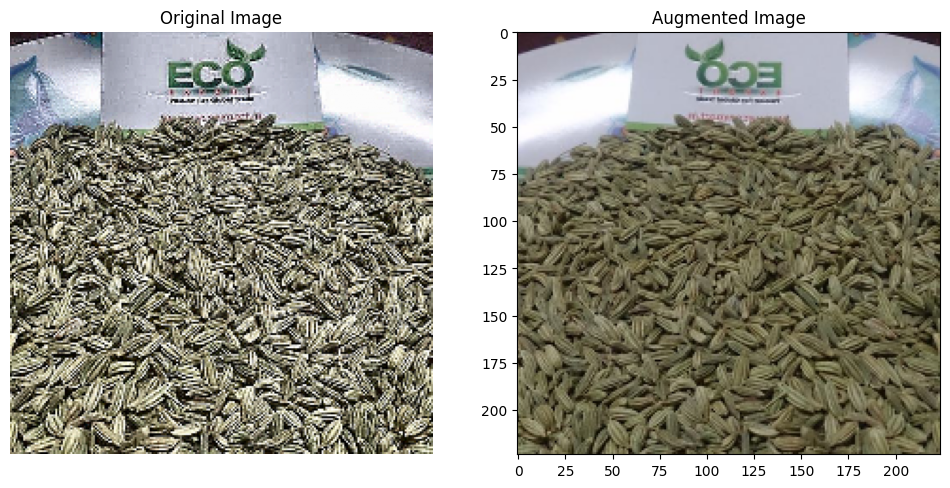

In [58]:
sample_image_path = random.choice(glob.glob(os.path.join(TRAIN_PATH, classes[0], "*.jpg")))
original = preprocess_image(sample_image_path)
augmented = apply_augmentation(sample_image_path)

show_images(original, augmented)
print("✅ Proses preprocessing dan augmentasi selesai!")

# Kualitas Visual Data

In [59]:
def is_blurry(image_path, threshold=100.0):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    return laplacian_var < threshold, laplacian_var


In [60]:
def get_brightness(image_path):
    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    brightness = hsv[:, :, 2].mean()
    return brightness


In [61]:
def check_image_dimension(image_path, expected_size=(224, 224)):
    image = cv2.imread(image_path)
    return image.shape[:2] == expected_size[::-1]  # (height, width) vs (width, height)
